/tmp/ipykernel_1023710/1757924661.py:15: RuntimeWarning: divide by zero encountered in log
  ee = np.sum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(xi)  # 这里除以了子系统长度  # 一定要用 np.sum()
/tmp/ipykernel_1023710/1757924661.py:15: RuntimeWarning: invalid value encountered in multiply
  ee = np.sum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(xi)  # 这里除以了子系统长度  # 一定要用 np.sum()


Mz = 2.5000000000000004 (25 / 25)
i = 24, elapsed time: 334.3 s


/home/DHJ/.conda/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/DHJ/.conda/envs/py312/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


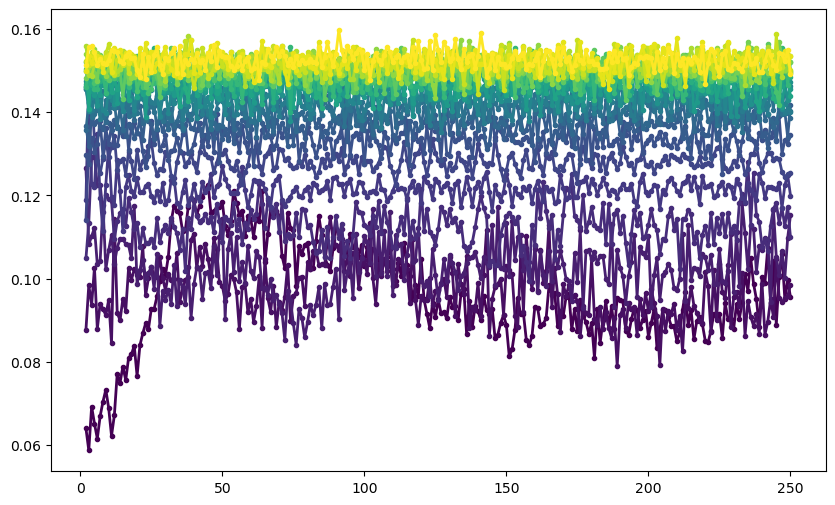

In [ ]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import time


def cal_entanglement_spectrum(init_state, H_evo, dt):
    psi_t = expm( - 1j * H_evo * dt) @ init_state  # 别忘了 numpy 的矩阵乘法是 @
    Cor = psi_t @ psi_t.conj().T
    Cor_subsys = Cor[0:np.size(Cor, 0) // 2, 0:np.size(Cor, 1) // 2]  # 注意 python 要求索引的数据类型必须完全是 int ，而且注意索引从0开始！！
    xi, _ = np.linalg.eig(Cor_subsys)
    return xi

def cal_entanglement_entropy(xi):
    ee = np.sum( - xi * np.log(xi) - (1 - xi) * np.log(1 - xi)) / len(xi)  # 这里除以了子系统长度  # 一定要用 np.sum()，不要直接 sum
    # 另外 np.sum() 对 nan 值怎么处理，比如 log(0)
    return ee


def gen_H_mosaic1_momentum(L, t0, Mz, beta, phi=0):
    Ham = np.zeros((L, L), dtype=np.complex128)
    V = np.zeros(L, dtype=np.complex128)
    for i in range(L):
        if i % 2 == 0:
            V[i] = 0
        else:
            V[i] = 2 * Mz * np.cos(2 * np.pi * beta * (i + 1) + phi)
        Ham[i, i] = t0 * 2 * np.cos(i * 2 * np.pi / L)
    for i in range(L):
        for j in range(L):
            Ham[i, j] += np.sum(V / L * np.exp( - 1j * (i - j) * 2 * np.pi / L * np.arange(L, dtype=np.complex128)))  # * 是按元素乘法， @ 是矩阵乘法
    return Ham


if __name__ == "__main__":
    L = 320  #
    t0 = 1
    Mz_array = np.arange(0.1, 2.5 + 0.001, 0.1)
    beta = (np.sqrt(5) - 1) / 2  #
    phi = 0
    # EF = L // 4
    steps = 250
    dt = 25  #

    for i in range(1, 8):
        EF = L // 8 * i
        start_time = time.time()
        H_0 = gen_H_mosaic1_momentum(L, t0, 0, beta, phi)
        e, Vr = np.linalg.eig(H_0)
        init_state = Vr[:, 0:EF]

        S_array = np.zeros((len(Mz_array), steps), dtype=np.complex128)
        xi_array = np.zeros((len(Mz_array), steps, L // 2), dtype=np.complex128)
        for i, Mz in enumerate(Mz_array):
            H_evo = gen_H_mosaic1_momentum(L, t0, Mz, beta, phi)

            for j in range(steps):
                xi = cal_entanglement_spectrum(init_state, H_evo, dt * j)
                S_array[i, j] = cal_entanglement_entropy(xi)
                xi_array [i, j, :] = xi
        print(f"Mz = {Mz} ({i + 1} / {len(Mz_array)})")
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(Mz_array)))
        plt.figure(figsize=(10, 6))
        for i, Mz in enumerate(Mz_array):
            plt.plot(np.arange(1, steps+1e-3), S_array[i, :], marker=".", linewidth=2, label=r"$M_z=%.2f$" % (Mz), color=colors[i])

        end_time = time.time()
        print(f"i = {i}, elapsed time: {end_time - start_time:.1f} s")

